# Introduction

This notebook provides a brief introduction to decision trees using the "Census Income" or "Adult" data set from the UCI Machine Learning repository. This data set takes census information on individual people so that we can try to predict whether or not that person earned more than $50,000. The data and its description can be found at http://archive.ics.uci.edu/ml/datasets/Adult.

The work below includes the following:
 - Data munging and visualization
 - Label encoding of categorical features
 - Basic decision tree classifier
 - Random forest classification
 - AdaBoost classifier
 - XGBoost classifier
 - Grid search cross-validation
 - Randomized search cross-validation


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Data Preparation

First, we need to read the data. It turns out that the raw file from the UCI ML site has no header, so we want to add the feature names ourselves.

In [76]:
cols = ['age','workclass','fnlwgt','education','education-num',
        'marital-status','occupation','relationship','race',
        'sex','capital-gain','capital-loss','hours-per-week',
        'native-country','target']

data = pd.read_csv('adult.data',header=None,names=cols)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Now, we should check to see if everything was read in properly.

In [77]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
target            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


This looks good. The numeric features are numeric types, and there are no null values. There are a lot of categorical features, so we should check their different unique values.

In [78]:
categoricals = ['workclass','education','marital-status',
                'occupation','relationship','race','sex',
                'native-country','target']

for col in categoricals:
    print(data[col].unique())

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
[' Male' ' Female']
[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' 

We can see that there are no obvious mis-spelled words here. This means that we don't have to worry about correcting the text. We also see that there are unknown values, given by '?'.

Also note that there is a space before each feature. This is because the data set actually uses a comma and a space to separate fields rather than just a comma. We did not try to correct this in the file or try to figure out how to maybe tell pandas that this is not a normal csv file. This is not a problem because we can just use something like the map() function to remove the whitespace.

In [79]:
for col in categoricals:
    data[col] = data[col].map(lambda x : x.strip())

Now, let's plot histograms of the categorical features. We'll make a function to do this and then run it.

In [80]:
def plot_values(col,ax,log=False):
    counts= data[col].value_counts()
    names = counts.index
    values = counts.values
    ind = np.arange(len(values))
    ax.bar(ind,values)
    ax.set_xticks(ind)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    ax.set_xticklabels(names,rotation=90,size=18)
    ax.set_xlabel(col,size=20)
    ax.set_ylabel('Number',size=20)
    if log is True:
        ax.set_yscale('log')

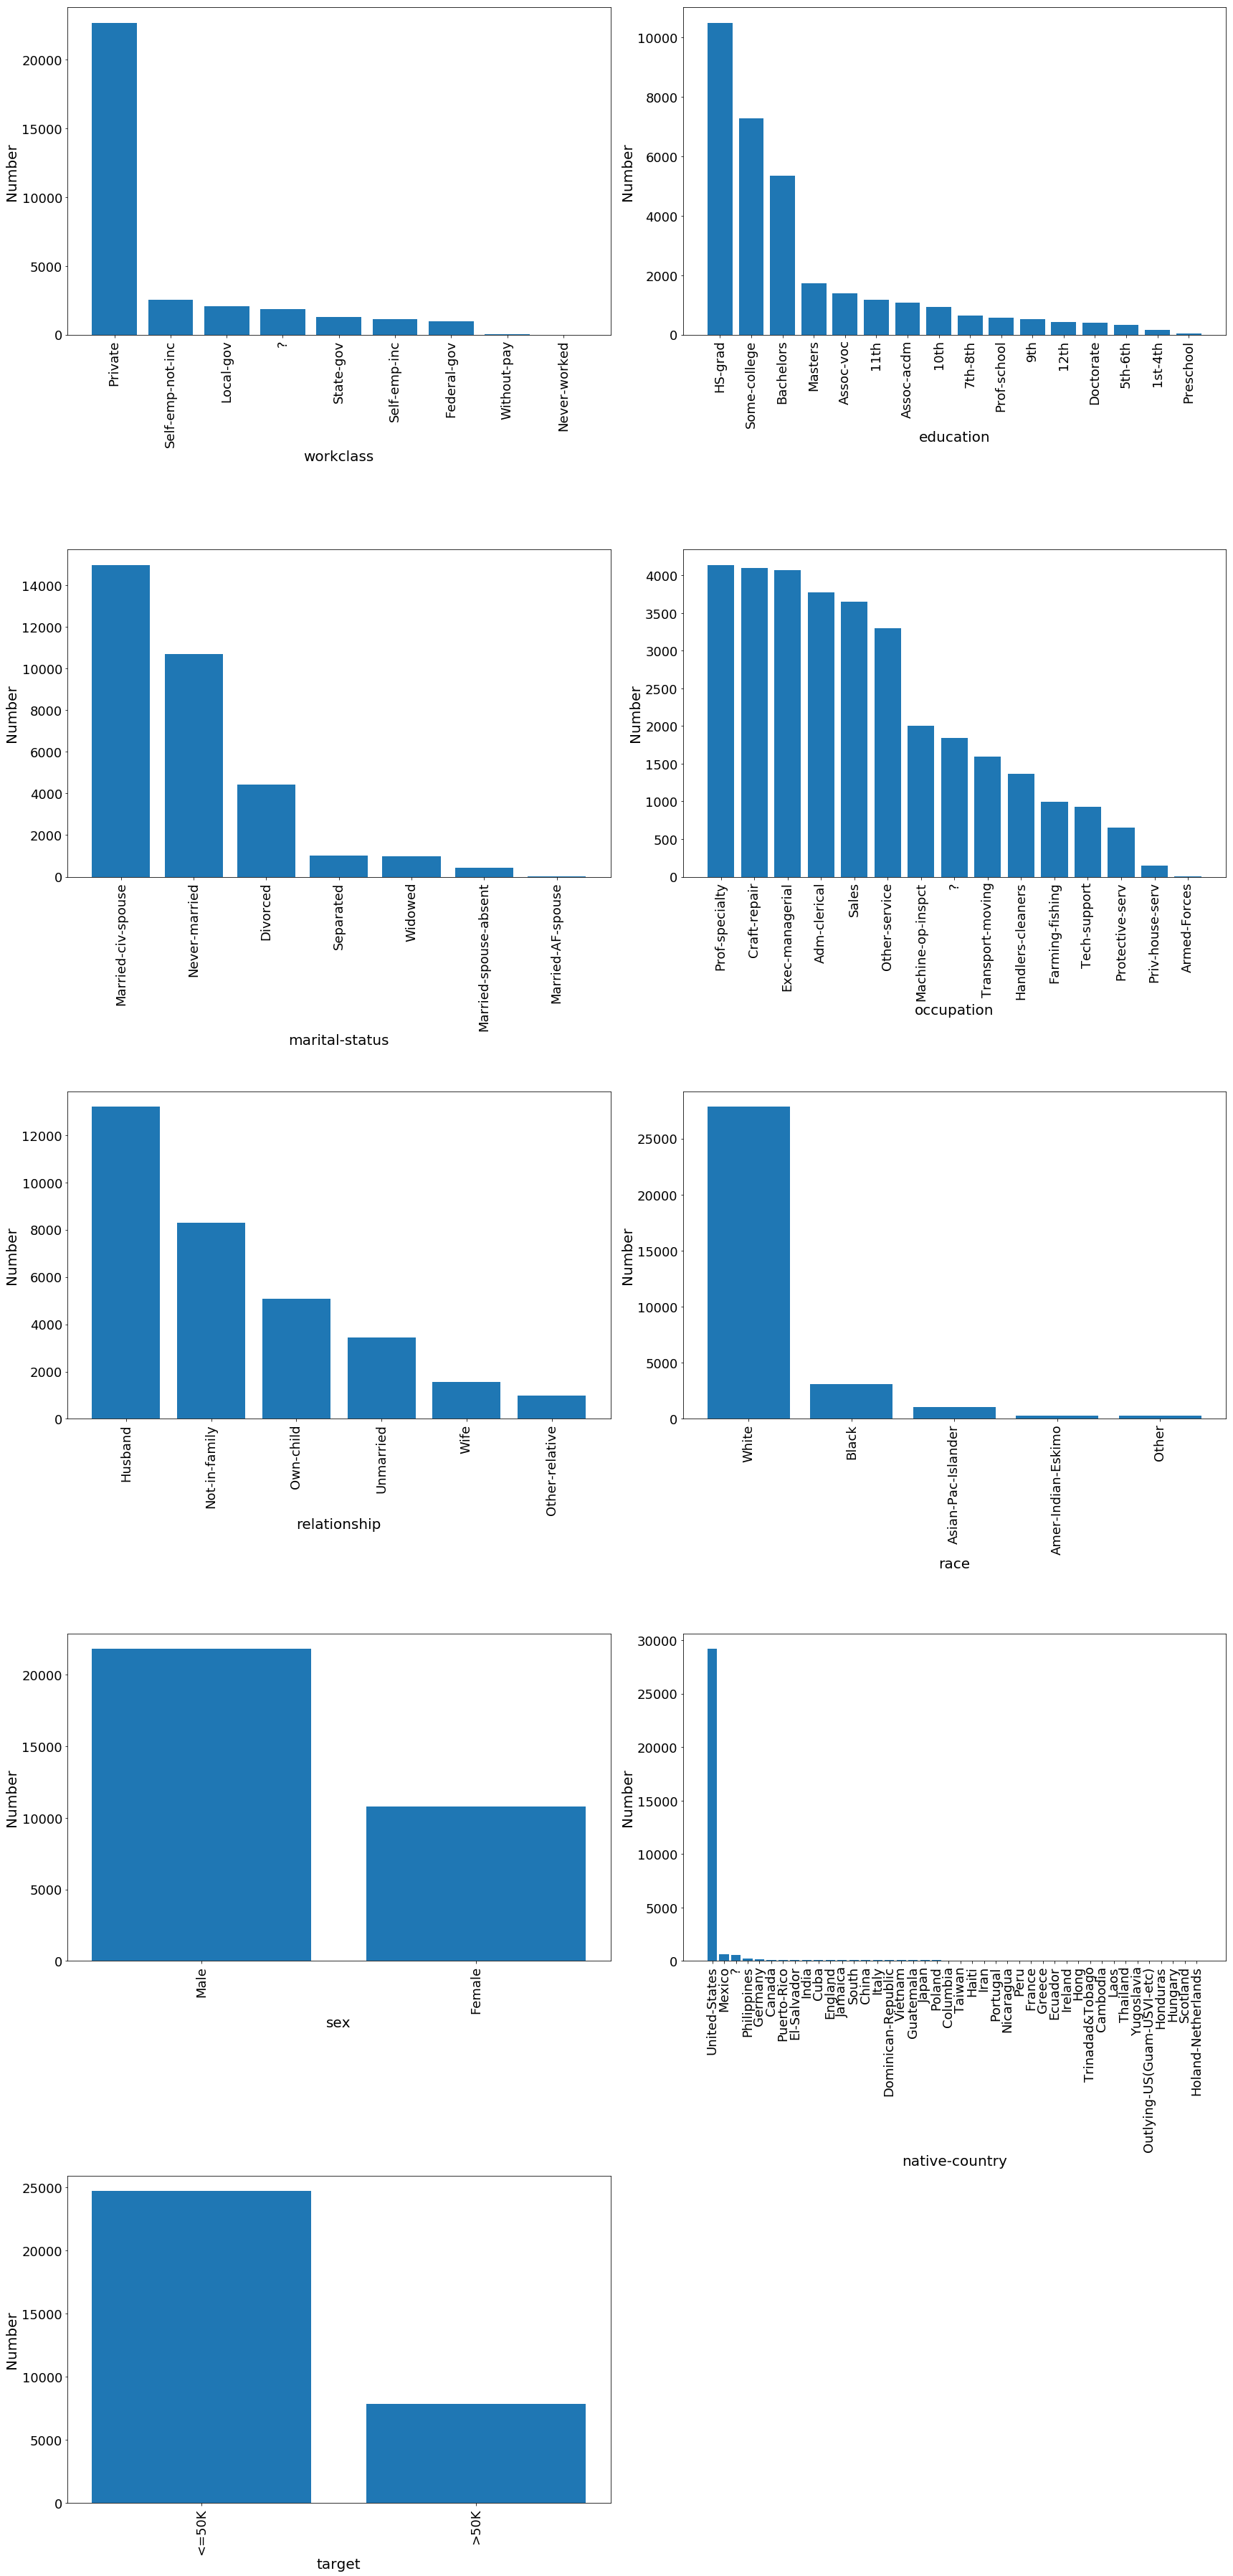

In [81]:
fig = plt.figure(1,figsize=[24,50])


for idx,col in enumerate(categoricals):
    ax = fig.add_subplot(5,2,idx+1)
    plot_values(col,ax)
plt.tight_layout()
plt.show()

We see that our target is actually fairly imbalanced. There is around 3 times a many entries in the "<=50K" class as in the ">50K" class. We also see that there are a fairly significant fraction of entries with '?' in at least one field, so we probably don't want to just throw those away. It is likely that such entries will still exist in any new data, so our predictions will want to take these into account.

There are some plots where there is a huge difference between the most common and least common options. We cannot even see the values for some features (native-country is particularly bad). Let's make the same plots but with logarithmic y scales.

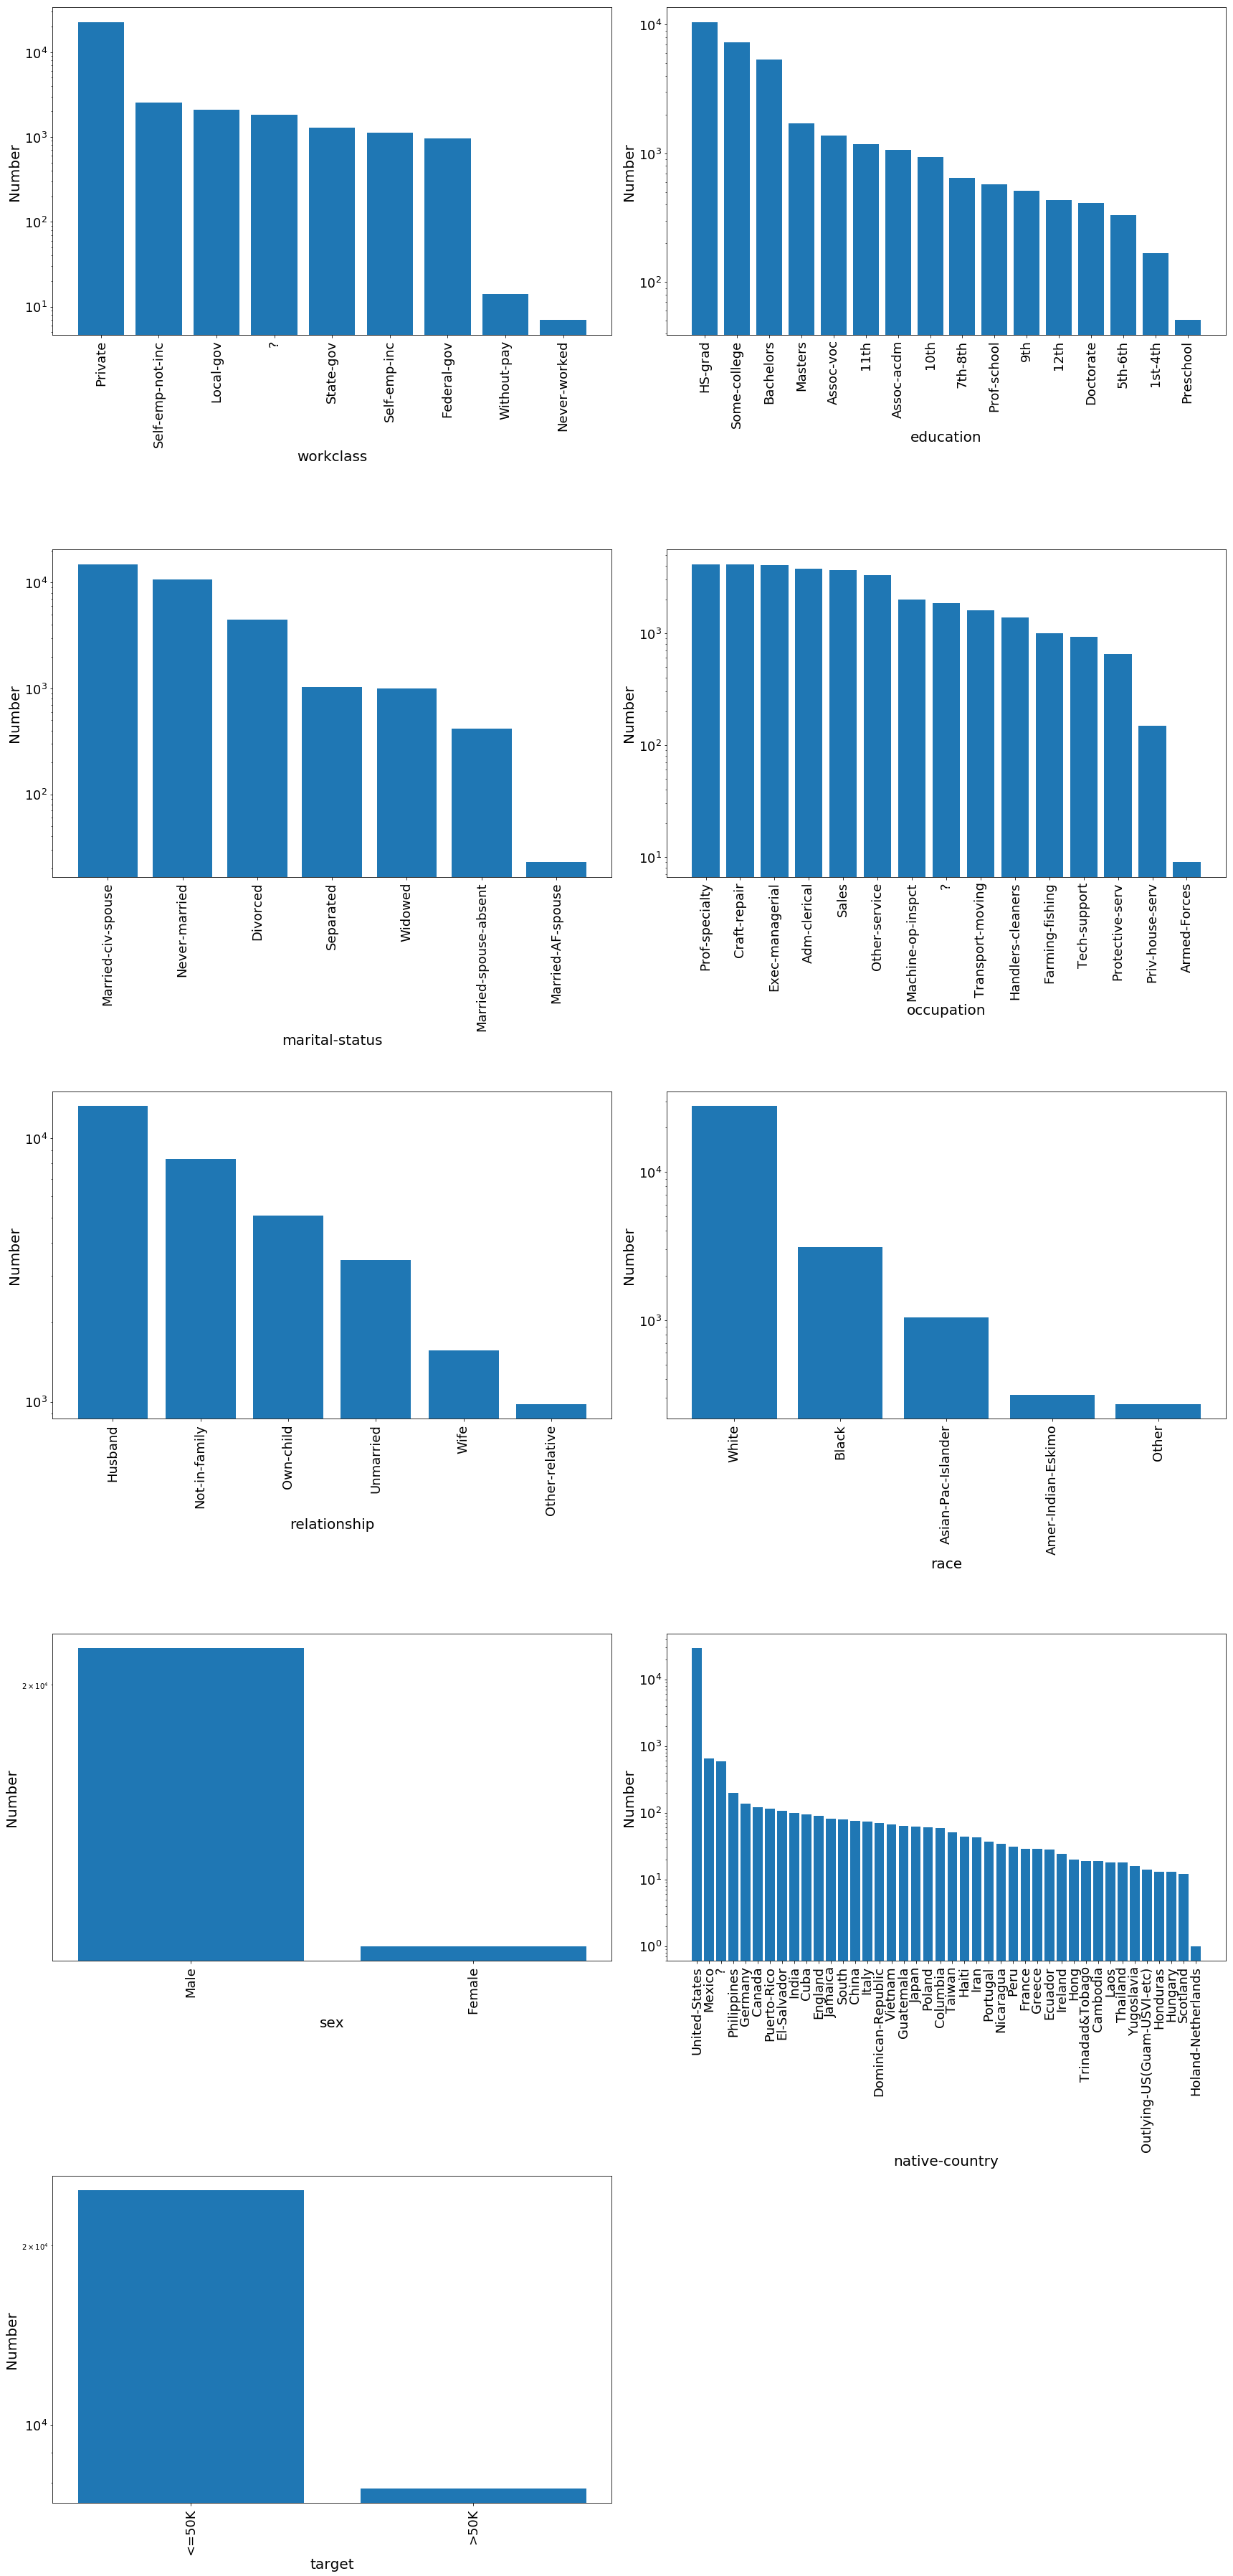

In [82]:
fig = plt.figure(1,figsize=[24,50])


for idx,col in enumerate(categoricals):
    ax = fig.add_subplot(5,2,idx+1)
    plot_values(col,ax,log=True)
plt.tight_layout()
plt.show()

There are several categories where there are fewer than 10 entries. I will set these values to '?', since we probably do not want to include these. We could alternatively attempt to combine these with similar categories. It might even be better to remove the labels or combine labels for categories with less than several dozen or even 100 entries.

In [83]:
data.loc[data['native-country']=='Holand-Netherlands','native-country'] = '?'
data.loc[data['occupation']=='Armed-Forces','occupation'] = '?'
data.loc[data['workclass']=='Never-worked','workclass'] = '?'


We should also plot the numerical features. As before, I'll do this with both linear and logarithmic y scales.

In [84]:
numeric = ['age','fnlwgt','capital-gain','capital-loss','hours-per-week']

def plot_num(col,ax,log=False):
    ax.hist(data[col],bins=20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    ax.set_xlabel(col,size=20)
    ax.set_ylabel('Number',size=20)
    if log is True:
        ax.set_yscale('log') 

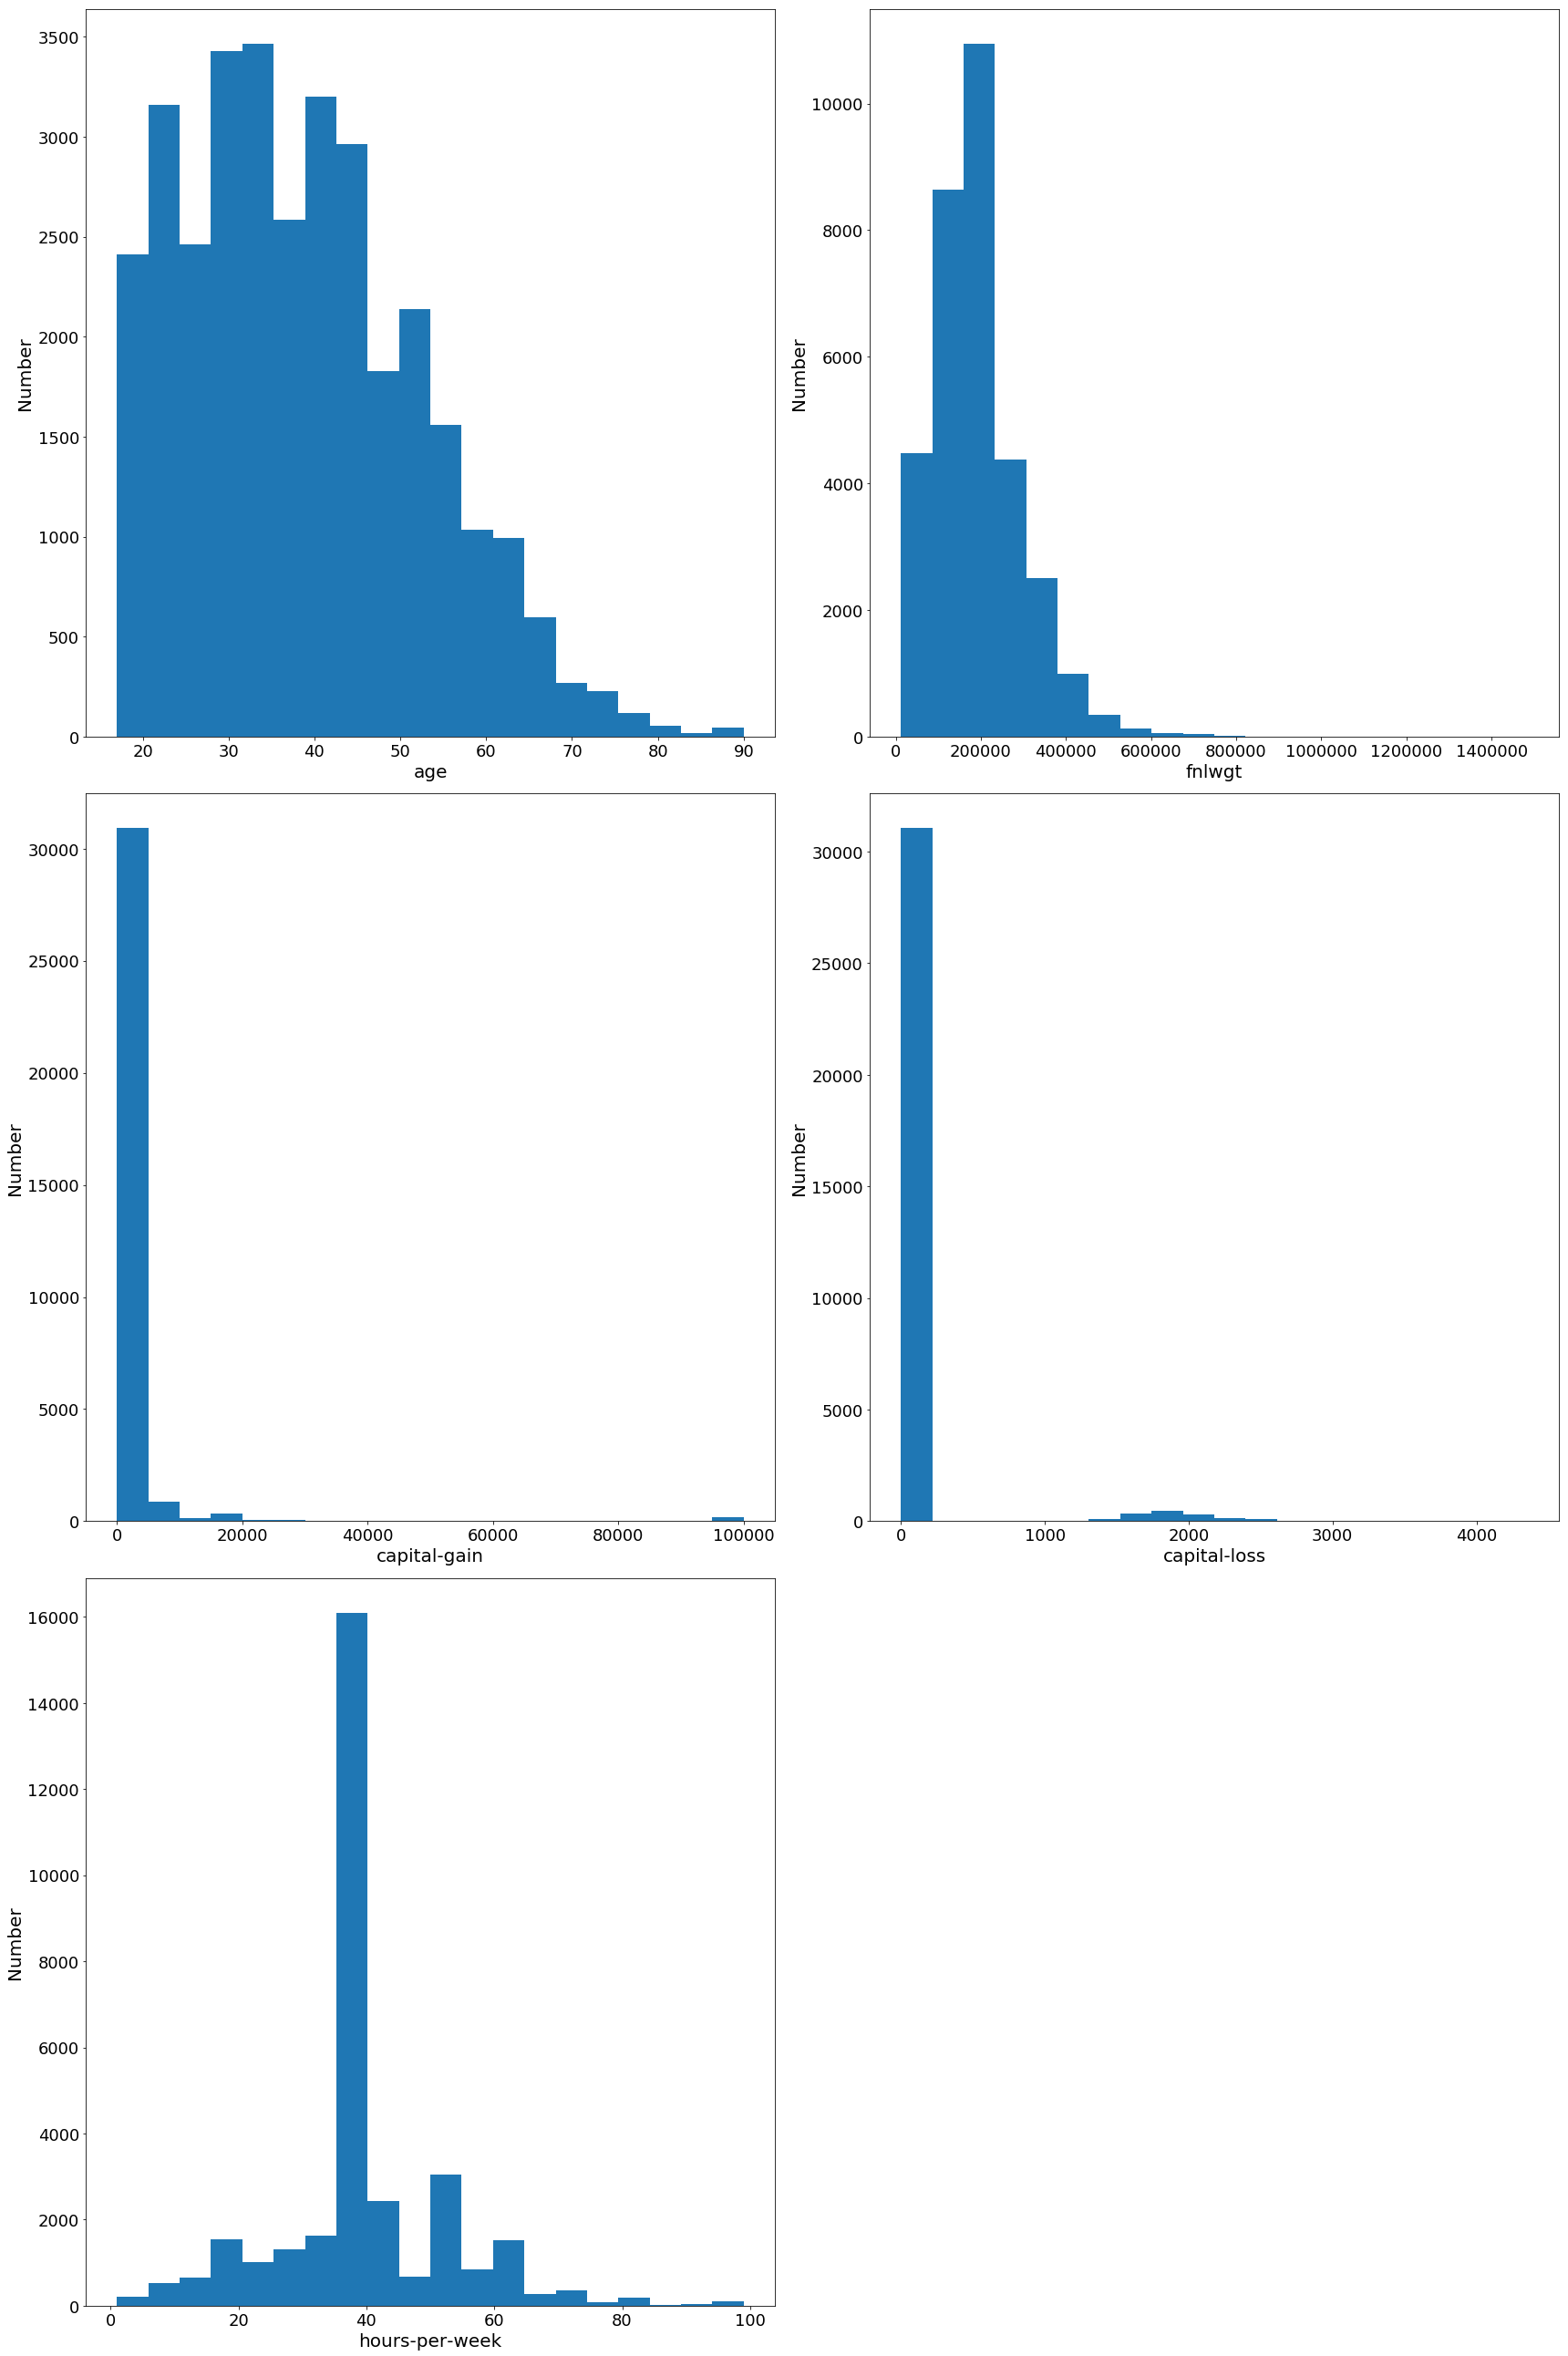

In [86]:
fig = plt.figure(1,figsize=[24,36])


for idx,col in enumerate(numeric):
    ax = fig.add_subplot(3,2,idx+1)
    plot_num(col,ax,log=False)
plt.tight_layout()
plt.show()

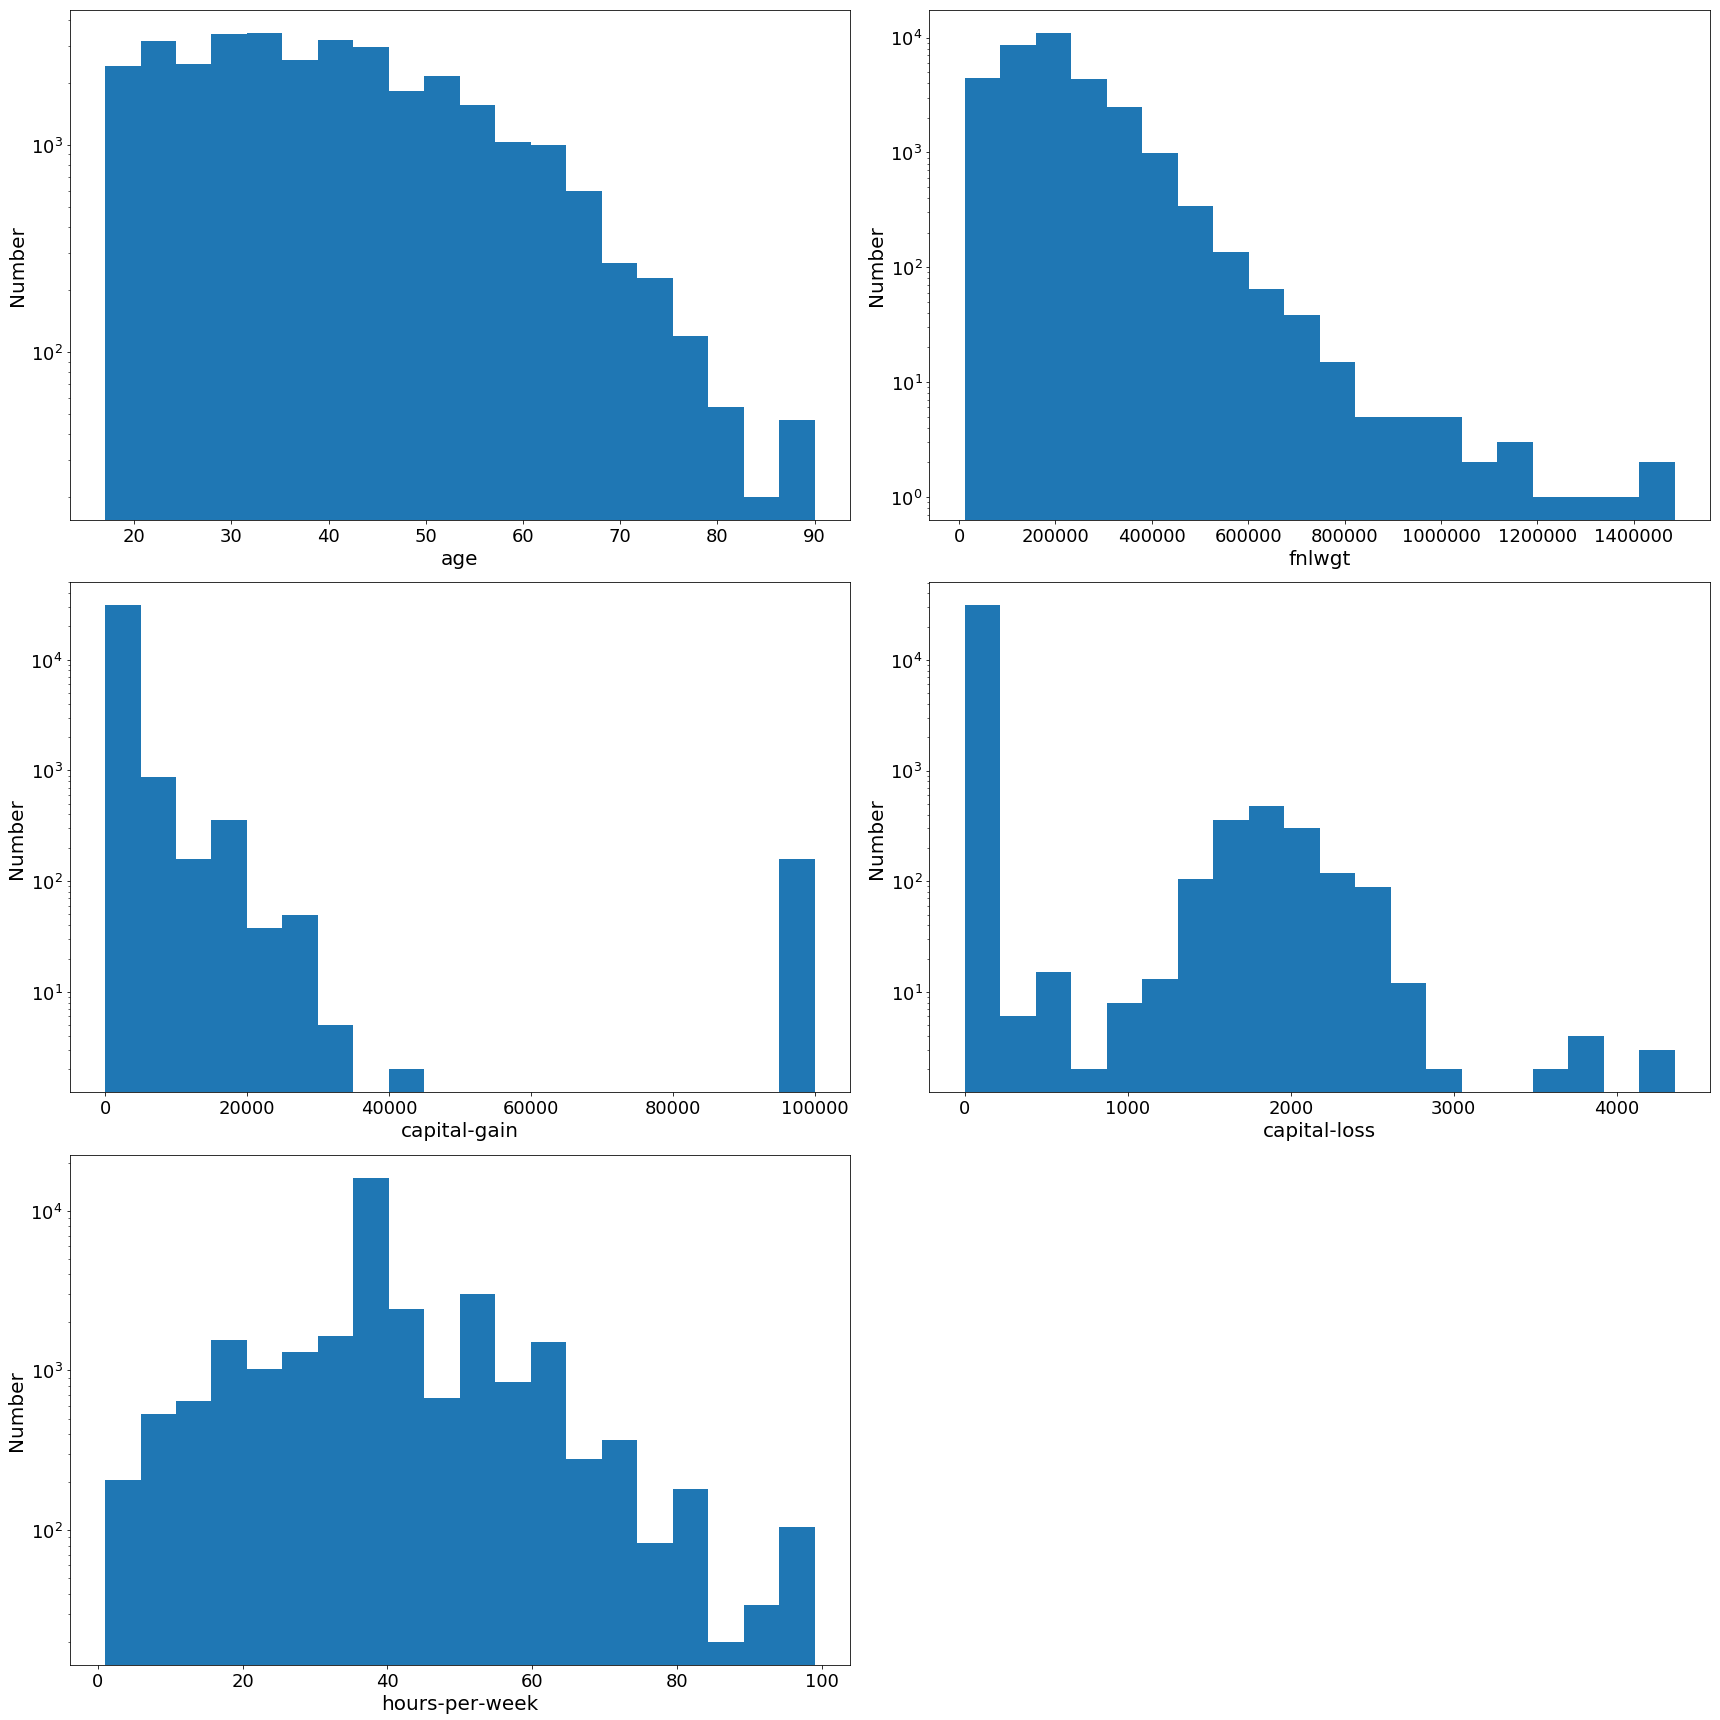

In [87]:
fig = plt.figure(1,figsize=[24,24])


for idx,col in enumerate(numeric):
    ax = fig.add_subplot(3,2,idx+1)
    plot_num(col,ax,log=True)
plt.tight_layout()
plt.show()

Age is fairly flat until around age 45 and then starts to drop. The documentation says that only entries with nonzero hours per week worked are chosen, so both retirements and death will cause the number to start dropping. 

We can see that capital gains and losses are 0 for most entries, with capital loss having a peak at around 2000. Many workers report 40 hours worked, but with a distribution ranging up to around 100 hours.

The weights (which I won't use in this notebook) have an almost exponential distribution.

#### Preparing Categorical Data

I'm going to be running decision trees to make my predictions here. Scikit-learn trees are not able to take labels, so I must convert everything to numeric types. Decision trees can make a variety of cuts on any feature, so I can just map everything to integers without expanding the overall number of features. This is easy for binary data (map everything to a 0 or 1).

For the other features, I will do something more complicated. The trees try to make decisions based on how much improvement they get with a particular split. To maybe help aid this, I will order the categories based on what the fraction of '>50K' entries is for that category. I will also set any '?' or previously-unseen options to a value of -1 so that splits can still take place based on those values.

In [89]:
category_labels = {}
category_inverse_labels = {}
data['target'] = data['target'].map(lambda x : 1 * (x=='>50K'))

print(data.head())
for col in categoricals[:-1]:
    uniques = data[col].unique()
    uniques = uniques[uniques!='?'] # Want to set to NaN
    data[col+'_tmp'] = data[col].astype('category')
    data[col+'_tmp'] = data[col+'_tmp'].cat.set_categories(uniques)
    ordered_labels = data.groupby(col+'_tmp')['target'].mean().sort_values().index
    label_map = {}
    inverse_map = {}
    for idx,label in enumerate(ordered_labels):
        label_map[label] = idx
        inverse_map[idx] = label
        
    category_labels[col] = label_map # Can use for new data sets
    category_inverse_labels[col] = inverse_map
    data[col] = data[col].map(label_map,na_action='ignore')
    data[col] = data[col].fillna(-1)
    data[col] = data[col].astype('int8')
    data = data.drop(col+'_tmp',axis=1)
    
print(data.head())


   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country  target  
0          2174             0              40  United-States       0  
1             0             0           

As I mentioned, I'm not going to use the weights right now, so I'll drop those. I will also drop 'education-num' because 'education' and 'education-num' contain the same information.

In [90]:
data_clean = data.drop(['education-num','fnlwgt'],axis=1)

We should also quickly check some stats on one of the categorical features to make sure that the values look sensible.

In [91]:
data_clean.workclass.describe()

count    32561.000000
mean         1.564448
std          1.472214
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: workclass, dtype: float64

# Basic Decision Tree

Let's now just fit on an untuned decision tree. I will use the sklearn.model_selection.cross_validate function (new in sklearn 0.19) to evaluate the model. This uses a stratified k-fold cross validation to report scores.

In this notebook, I will use the F1 score as the main classification metric, as this will tend to work better on imbalanced data than a raw accuracy score. However, for this initial test, I will also weight the events in order to effectively rebalance the data. I don't show it here, but it actually turns out that we often get better results on this data without adding the class weights.

In [92]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection as ms
from sklearn import metrics


y = data_clean['target'].as_matrix()
X = data_clean.drop('target',axis=1).as_matrix()
mean_y = np.mean(y)
dtc = DecisionTreeClassifier(class_weight={0:1,1:1/mean_y})
print('Trivial model F1 score: {:0.4}'.format(2*mean_y/(1+mean_y)))
def run_cv(mod):
    scores = ms.cross_validate(mod,X,y,cv=10,scoring='f1')

    test = scores['test_score']
    train = scores['train_score']
    print('F1 Score:')

    print('\tTrain: {:0.4} +/- {:0.4}'.format(np.mean(train),
                                          np.std(train)))
    print('\tValid.:  {:0.4} +/- {:0.4}'.format(np.mean(test),
                                          np.std(test)))
    
    scores = ms.cross_validate(mod,X,y,cv=10,scoring='accuracy')

    test = scores['test_score']
    train = scores['train_score']
    print('Accuracy Score:')

    print('\tTrain: {:0.4} +/- {:0.4}'.format(np.mean(train),
                                          np.std(train)))
    print('\tValid.:  {:0.4} +/- {:0.4}'.format(np.mean(test),
                                          np.std(test)))

run_cv(dtc)

Trivial model F1 score: 0.3881
F1 Score:
	Train: 0.94 +/- 0.001274
	Valid.:  0.6314 +/- 0.01773
Accuracy Score:
	Train: 0.9694 +/- 0.0007068
	Valid.:  0.8133 +/- 0.007117


We see that this simple model already beats the trivial model where we choose '>50K' for every entry. However, we can see that we are overfitting quite badly. The F1 score is 0.94 on our training set but only 0.63 on our validation sets. The same is seen for the accuracy score. This model is thus better than nothing but still needs work.

# Grid Search Cross Validation

We can tune some of the decision tree parameters using cross validation. However, we want to tune all parameters at the same time to ensure that we get the best results given the possible parameters that we consider. A grid search CV is a good way to do this. We simply select some values for a set of parameters and then calculate the CV score for all possible combinations. This works for a small number of parameters but rapidly gets out of control if there are many parameters.

Here, I will tune the miminum number of allowed samples in any leaf and the maximum tree depth. Both of these will help avoid overfitting by limiting the number of possible splits. I have already done some testing on all of these to get a decent scale for the parameters. In general, we might want to start with a wider set of parameter values and then iteratively start narrowing the range of interest.

In [94]:
from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier()
params = { 'min_samples_leaf':[1,3,5,7],
           'max_depth':[7,9,11,13,15]
    
          }

gs_cv = GridSearchCV(dtc,params,scoring='f1',cv=10)
gs_cv.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [95]:
print('Best F1: {:0.3}'.format(gs_cv.best_score_))
print('For parameters:',gs_cv.best_params_)

Best F1: 0.684
For parameters: {'max_depth': 13, 'min_samples_leaf': 3}


Based on the F1 score, our best parameters are a maximum depth of 13 and no fewer than 3 samples per leaf.

In [96]:
dtc = DecisionTreeClassifier(max_depth=13,min_samples_leaf=3)
run_cv(dtc)

F1 Score:
	Train: 0.7403 +/- 0.004672
	Valid.:  0.6826 +/- 0.01606
Accuracy Score:
	Train: 0.8841 +/- 0.001033
	Valid.:  0.8583 +/- 0.006551


These parameters give us an F1 score of 0.68 and an accuracy of 86%, a significant increase over our naive untuned model. We also see that the gap between the training and validation scores is much smaller, so we have greatly reduced overfitting.

# Random Forest

A single decision tree is quite prone to overfitting, so we can try to avoid that by using a random forest classifier. This type of classifier trains on bootstrapped samples of the data and produces a "forest" of independent decision trees that are combined to get a single prediction.

We can run the grid search CV again. This time, I will look at the minimum samples per leaf and the number of trees. I will allos the trees to grow to arbitrary size. I will also only use a 5-fold CV for the grid search to help speed things up.

In [99]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
params = { 'min_samples_leaf':[1,3,5,7],
           'n_estimators':[25,50,100,150]
          }

gs_cv = GridSearchCV(rfc,params,scoring='f1',cv=5)
gs_cv.fit(X,y)
print('Best F1: {:0.3}'.format(gs_cv.best_score_))
print('For parameters:',gs_cv.best_params_)

Best F1: 0.698
For parameters: {'min_samples_leaf': 3, 'n_estimators': 100}


Our best parameters are 3 samples per leaf and 50 estimators. I haven't set the seed for the k-fold CV, so sometimes this gives other values. Evidently, our results are not particularly sensitive to the parameters.

In [47]:
rfc = RandomForestClassifier(min_samples_leaf=3,n_estimators=50)
run_cv(rfc)

F1 Score:
	Train: 0.7809 +/- 0.002096
	Valid.:  0.6942 +/- 0.01352
Accuracy Score:
	Train: 0.9028 +/- 0.000944
	Valid.:  0.8671 +/- 0.005943


The random forest gives us an improvement of 0.01 over the single tree in both of the scores that we see here. That is not much but it is significant for a 10-fold CV. Note that the errors reported are the standard deviation of the folds and not the standard error of the mean.

# Boosted Decision Trees

While a forest combines a number of independent trees, boosting is a method to combine many trees in such a way that each tree is dependent on those that were trained before it. Boosting is a method to take a number of models and combine them by finding which combination of models works best. The different models get weights, so the final result is not just the average or majority vote of all models.

Adaptive boosting (AdaBoost) is one such boosting model. In AdaBoost, the weights end up being dependent on which entries received incorrect predictions. 

There are various pros and cons on whether a forest or boosting is better for any data set. A forest can be calculated in parallel, allowing for much faster processing than boosting. Boosting tends to combine many weak learners, so in some cases it may require a very large number of learners to get good results. The strategies are also different, so things like overfitting will be different for the different types of classifiers.

In [54]:
from sklearn.ensemble import AdaBoostClassifier

# A weak learner
base = DecisionTreeClassifier(min_samples_leaf=3,max_depth=3)

abc = AdaBoostClassifier(base_estimator=base)

params = { 'learning_rate':[0.1,0.3,0.5],
           'n_estimators':[125,150,200]
          }

gs_cv = GridSearchCV(abc,params,scoring='f1',cv=5)
gs_cv.fit(X,y)
print('Best F1: {:0.3}'.format(gs_cv.best_score_))
print('For parameters:',gs_cv.best_params_)


Best F1: 0.714
For parameters: {'learning_rate': 0.3, 'n_estimators': 150}


In [55]:
abc = AdaBoostClassifier(base_estimator=base,learning_rate=0.3,n_estimators=150)
run_cv(abc)

F1 Score:
	Train: 0.7373 +/- 0.0009375
	Valid.:  0.7111 +/- 0.009141
Accuracy Score:
	Train: 0.8825 +/- 0.0004527
	Valid.:  0.8714 +/- 0.003959


Here, we see that for our best parameters, AdaBoost gives us another 0.015-0.02 improvement in our F1 score and a slight improvement in the overall accuracy. There is also better agreement between the training and validation scores than for the other models that we've tried.

# XGBoost

XGBoost is a separate package that is compatible with scikit-learn. It provides a type of gradient boosting, which is another boosting algorithm.

Let's see how XGBoost does if we use the same parameters as for AdaBoost.

In [66]:
import xgboost as xgb

xgc = xgb.XGBClassifier(max_depth=3,learning_rate=0.3,n_estimators=150)
run_cv(xgc)

F1 Score:
	Train: 0.7315 +/- 0.002095
	Valid.:  0.7161 +/- 0.007978
Accuracy Score:
	Train: 0.8811 +/- 0.0006181
	Valid.:  0.8746 +/- 0.003356


Results are pretty similar, with maybe a slight improvement.

# Randomized Search CV

XGBoost is a different algorithm, so the optimal parameters are not necessarily the same as we got for AdaBoost. We should redo the cross validation.

However, there are many possible parameters. In fact, there are too many for the grid search to work well. Instead, we can use a randomized search CV. Here, we can simultaneously draw values from many parameters based on random distributions that we choose. This allows us to map out our parameter space without needing to do calculations on a huge grid of points.

Here, I will choose the depth, learning rate, number of estimators, L1 and L2 regularization strength, and "gamma," which is another regularization parameter. We can run the randomized search for a number of iterations (I chose 40) and pick the best. This won't necessarily be as good as the best grid search value but will hopefully arrive at an answer that is close in much less time.

In [100]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
params = {'max_depth':randint(2,4),
          'learning_rate':uniform(0.05,1),
          'n_estimators':randint(50,200),
          'gamma':uniform(0,0.5),
          'reg_alpha':uniform(0,1),
          'reg_lambda':uniform(0,1)  
         }

rsc = RandomizedSearchCV(xgc,params,n_iter=40,scoring='f1',cv=5,random_state=987)

rsc.fit(X,y)
print('Best F1: {:0.3}'.format(rsc.best_score_))
print('For parameters:',rsc.best_params_)

Best F1: 0.715
For parameters: {'gamma': 0.2029845631245783, 'learning_rate': 0.44223910795941862, 'max_depth': 3, 'n_estimators': 104, 'reg_alpha': 0.45912921802895357, 'reg_lambda': 0.84891584962403077}


In [74]:
run_cv(rsc.best_estimator_)

F1 Score:
	Train: 0.7324 +/- 0.001814
	Valid.:  0.7153 +/- 0.007541
Accuracy Score:
	Train: 0.8811 +/- 0.0005939
	Valid.:  0.8734 +/- 0.002379


In this case, we haven't really found a significantly better solution than before. Perhaps there is some other parameter that might help. But, given that we are mostly seeing very similar results from all of these tree models, we might want to go back to our data to see if we can engineer some new features or maybe remove some problematic entries to improve things. We could also try out a different approach and use another technique to do the classification to see if something else gets better results.

# Conclusions

We've tested several decision tree models to classify people by income based on census data. The best results we get here have an F1 score of 0.715 (this is used for selecting model parameters) and an accuracy score of over 87%.